<a href="https://colab.research.google.com/github/Aliaksandr-Borsuk/Recommender_Systems_project/blob/main/notebooks/001_data_and_eda_1m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The first date.)  

В этом ноутбуке:
- Загружаем MovieLens *('1m').*
- Cтроим EDA.
- Обосновываем стратегию split для валидации и сплитуем данные.
- Сохраняем для повторяемрости.
- Строим Baseline.

# Общая подготовка

In [1]:
# подключаем диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.Установка зависимостей.

In [2]:
# Python-пакеты
!pip install -q rs_datasets plotly seaborn pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.9/429.9 kB 14.2 MB/s eta 0:00:00


## 2.Импорты

In [3]:
# 1. Импорты, настройки
import warnings
warnings.filterwarnings("ignore")

import math
from scipy import stats
import json
from pathlib import Path
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
from datetime import datetime
from rs_datasets import MovieLens
from pprint import pprint

# Параметры отображения
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)
sns.set(style="whitegrid")

#
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

DATA =   Path("/content/drive/MyDrive/Colab Notebooks/data/")
RAW_DATA = DATA/"raw"
PROCESSED = DATA/"processed"
DATA.mkdir(exist_ok=True)

## 3. Загрузка **MovieLens**


In [ ]:
# Загрузка датасета через rs_datasets
ML_VER = '1m'  # можно менять на другие версии если что...
# сохраняем на диск в /content/drive/MyDrive/Colab Notebooks/data/raw/<ML_VER>
ml = MovieLens(ML_VER, path = RAW_DATA)
print(f"MovieLens версия: {ML_VER}")
ml.info()  # информация о доступных файлах.

MovieLens версия: 1m
ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


У датасета есть разные  [версии](https://files.grouplens.org/papers/harper-tiis2015.pdf)
  

![картинко](https://github.com/Aliaksandr-Borsuk/Recommender_Systems_project/blob/main/pictures/Number%20of%20ratings%20in%20MovieLens%20datasets.jpg?raw=true)

## 4.Чтение данных.

In [ ]:
# читаем данные
def get_df(movilens, name):
    try:
        df = getattr(movilens, name)
        print(f"Загружен {name}: shape={df.shape}  ", end ='\t')
        print(f"{name} columns:", df.columns.tolist())
        return df.copy()
    except Exception as e:
        print(f"{name} not available: {e}")
        return pd.DataFrame()

ratings = get_df(ml, "ratings")
items  = get_df(ml, "items")
users    = get_df(ml, "users")

Загружен ratings: shape=(1000209, 4)  	ratings columns: ['user_id', 'item_id', 'rating', 'timestamp']
Загружен items: shape=(3883, 3)  	items columns: ['item_id', 'title', 'genres']
Загружен users: shape=(6040, 5)  	users columns: ['user_id', 'gender', 'age', 'occupation', 'zip_code']


## 5. Подготовка вспомогательных столбцов ts и genres_list

In [ ]:
# Создадим дополнительные колонки: ts (datetime) и genres_list (список жанров)
df_r = ratings.copy()
df_i = items.copy()
df_u = users.copy()

# timestamp -> datetime
df_r['ts'] = pd.to_datetime(df_r['timestamp'], unit='s', errors='coerce')
# преобразуем rating в число
df_r['rating'] = pd.to_numeric(df_r['rating'], errors='coerce')


df_i['genres'] = df_i['genres'].fillna('(no genres listed)')
df_i['genres_list'] = df_i['genres'].str.split('|')


print("\ndf_r head")
display(df_r.head())
print("\ndf_i head")
display(df_i.head())


df_r head


,user_id,item_id,rating,timestamp,ts
0,1,1193,5,978300760,2000-12-31 22:12:40
1,1,661,3,978302109,2000-12-31 22:35:09
2,1,914,3,978301968,2000-12-31 22:32:48
3,1,3408,4,978300275,2000-12-31 22:04:35
4,1,2355,5,978824291,2001-01-06 23:38:11



df_i head


,item_id,title,genres,genres_list
0,1,Toy Story (1995),Animation|Children's|Comedy,"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),Adventure|Children's|Fantasy,"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama,"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]


## 6. Объединённый DataFrame для анализа

In [ ]:
# объединяем через item_id
df = df_r.merge(df_i, on='item_id', how='left', suffixes=('', '_item'))

print("Объеденённый df - shape:", df.shape)
display(df.head())

Объеденённый df - shape: (1000209, 8)


,user_id,item_id,rating,timestamp,ts,title,genres,genres_list
0,1,1193,5,978300760,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama,[Drama]
1,1,661,3,978302109,2000-12-31 22:35:09,James and the Giant Peach (1996),Animation|Children's|Musical,"[Animation, Children's, Musical]"
2,1,914,3,978301968,2000-12-31 22:32:48,My Fair Lady (1964),Musical|Romance,"[Musical, Romance]"
3,1,3408,4,978300275,2000-12-31 22:04:35,Erin Brockovich (2000),Drama,[Drama]
4,1,2355,5,978824291,2001-01-06 23:38:11,"Bug's Life, A (1998)",Animation|Children's|Comedy,"[Animation, Children's, Comedy]"


# EDA

## 7. Базовая статистика

In [ ]:
n_ratings = len(df)
n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()
density = round(n_ratings/n_users/n_items, 4 )

print("Всего рейтингов:", n_ratings)
print("Уникальных юзеров:", n_users)
print("Уникальных фильмов:", n_items)
print("Метки времени не содержат пропусков:", df['ts'].notna().any())
print(f"Плотность матрицы users/items: {density}")
print(f"Среднее число рейтингов на пользователя: {round(n_ratings/n_users, 2)}")
print(f"Среднее число рейтингов на предмет: {round(n_ratings/n_items, 2)}")

display(df['rating'].describe())

Всего рейтингов: 1000209
Уникальных юзеров: 6040
Уникальных фильмов: 3706
Метки времени не содержат пропусков: True
Плотность матрицы users/items: 0.0447
Среднее число рейтингов на пользователя: 165.6
Среднее число рейтингов на предмет: 269.89


,rating
count,1.000209e+06
mean,3.581564e+00
std,1.117102e+00
min,1.000000e+00
25%,3.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,5.000000e+00


### **замечено:**
- матрица users/items очень разрежена плотность - 4.47% (норма для рекомендательных систем )
- среднее рейтингов на пользователя ~165   и ~ 270 рейтингов на фильм хорошая активность пользователей и фильмы тож оценены достаточно
- средняя оценка 3.68 по 5-ти бальной шкале говорит о центральном распределении и нетрально/слегка положительном отношении users-items
- медиана и 75-й персентиль = 4.0 показывает небольшую скошенность вправо(юзеры склонны ставить оценки повыше)
- std ~ 1.12 разброс оценок умеренный

## 8.Оценки — гистограмма, boxplot, процентили, skew/kurtosis


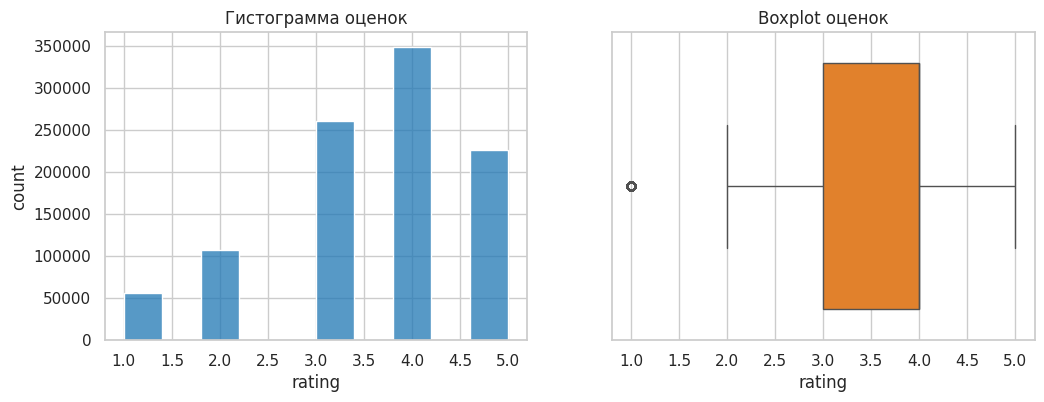

PПерсентили (1,5,25,50,75,95,99): [1. 1. 3. 4. 4. 5. 5.]
Ассиметрия (Skewness ): -0.5536, Эксцесс (Kurtosis ): -0.3520


In [ ]:
# распределение оценок
ratings_series = df['rating'].dropna()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(ratings_series, bins=10, kde=False, color='tab:blue')
plt.title("Гистограмма оценок")
plt.xlabel("rating")
plt.ylabel("count")

plt.subplot(1,2,2)
sns.boxplot(x=ratings_series, color='tab:orange', orient='h')
plt.title("Boxplot оценок")
plt.show()

percentiles = np.percentile(ratings_series, [1,5,25,50,75,95,99])
skewness = stats.skew(ratings_series)
kurtosis = stats.kurtosis(ratings_series)
print("PПерсентили (1,5,25,50,75,95,99):", percentiles)
print(f"Ассиметрия (Skewness ): {skewness:.4f}, Эксцесс (Kurtosis ): {kurtosis:.4f}")

### **замечено:**
- **Асимметрия и хвосты:** отрицательная асимметрия (skew ~ -0.55) - сдвиг влево, (kurtosis ~ -0.35) лёгкая нехватка остроты по сравнению с нормальным распределением, небльшой левый хост
- склонность юзеров к высоким оценкам (3-4), низкие оценки - редки
- IQR  от 3.0 до 5.0
- немножк явных низких выбросов , верхних выбросов практически нет

## 9. Активность пользователей

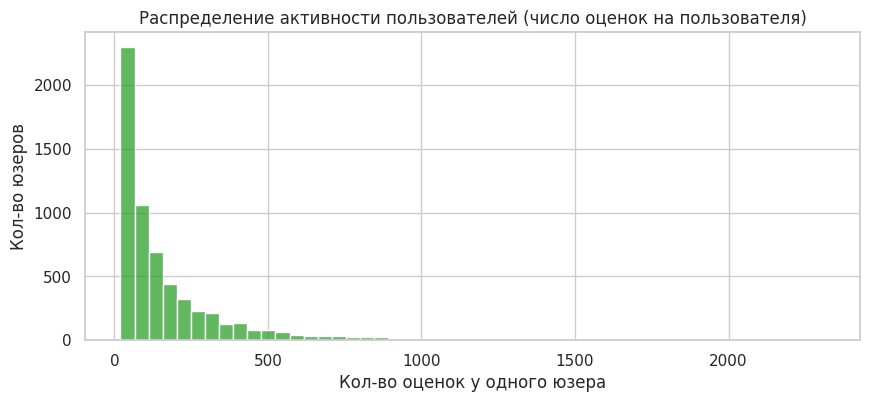

In [ ]:
# активность пользователей
user_activity = df.groupby('user_id')['rating'].count().sort_values(ascending=False)
plt.figure(figsize=(10,4))
sns.histplot(user_activity, bins=50, color='tab:green')
plt.title("Распределение активности пользователей (число оценок на пользователя)")
plt.xlabel("Кол-во оценок у одного юзера")
plt.ylabel("Кол-во юзеров")
plt.show()

### **замечено:**
- разреженность и долгий хвост
- нелинейный вклад пользователей
- проблема холодного старта (предсказания ненадёжны, коллаборативные методы (матричные факторизации, ALS, KNN) будут плохо работать)

## 10. Популярность и качество фильмов

In [ ]:
# популярность и качество фильмов
movie_agg = df.groupby(['item_id','title']).agg(
    n_ratings = ('rating','count'),
    mean_rating = ('rating','mean'),
    median_rating = ('rating','median'),
    std_rating = ('rating','std')
).reset_index().sort_values('n_ratings', ascending=False)

print("Top-10 фильмов по кол-ву оценок:")
display(movie_agg.head(10))

min_count = max(5, int(0.0001 * len(df)))  # порог для надежных средних
high_avg = movie_agg[movie_agg['n_ratings'] >= min_count].\
            sort_values('mean_rating', ascending=False).head(10)
print(f"\nTop-10 фильмов по рейтингу с кол-вом оценок >={min_count}:")
display(high_avg)

Top-10 фильмов по кол-ву оценок:


,item_id,title,n_ratings,mean_rating,median_rating,std_rating
2651,2858,American Beauty (1999),3428,4.317386,5.0,0.975133
253,260,Star Wars: Episode IV - A New Hope (1977),2991,4.453694,5.0,0.800781
1106,1196,Star Wars: Episode V - The Empire Strikes Back...,2990,4.292977,4.0,0.844432
1120,1210,Star Wars: Episode VI - Return of the Jedi (1983),2883,4.022893,4.0,0.927356
466,480,Jurassic Park (1993),2672,3.763847,4.0,0.969777
1848,2028,Saving Private Ryan (1998),2653,4.337354,5.0,0.845775
575,589,Terminator 2: Judgment Day (1991),2649,4.058513,4.0,0.904823
2374,2571,"Matrix, The (1999)",2590,4.315830,5.0,0.930918
1178,1270,Back to the Future (1985),2583,3.990321,4.0,0.865188
579,593,"Silence of the Lambs, The (1991)",2578,4.351823,5.0,0.831542



Top-10 фильмов по рейтингу с кол-вом оценок >=100:


,item_id,title,n_ratings,mean_rating,median_rating,std_rating
1839,2019,Seven Samurai (The Magnificent Seven) (Shichin...,628,4.560510,5.0,0.743607
309,318,"Shawshank Redemption, The (1994)",2227,4.554558,5.0,0.700443
802,858,"Godfather, The (1972)",2223,4.524966,5.0,0.780721
708,745,"Close Shave, A (1995)",657,4.520548,5.0,0.667143
49,50,"Usual Suspects, The (1995)",1783,4.517106,5.0,0.748822
513,527,Schindler's List (1993),2304,4.510417,5.0,0.763857
1066,1148,"Wrong Trousers, The (1993)",882,4.507937,5.0,0.708666
861,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),470,4.491489,5.0,0.740924
1108,1198,Raiders of the Lost Ark (1981),2514,4.477725,5.0,0.725647
843,904,Rear Window (1954),1050,4.476190,5.0,0.688946


### **замечено:**
- в топе в основном известная классика со стабильной средней оценкой

## 11. Корреляция средней оценки и кол-ва оценок

Корреляция средней оценки и популярности: 0.3580


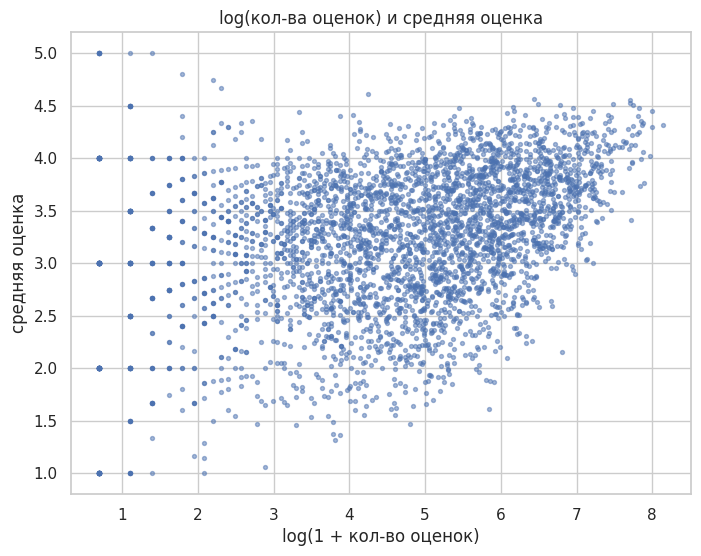

In [ ]:
# Корреляция средней оценки и кол-ва оценок (популятности) фильмов
corr = movie_agg['n_ratings'].corr(movie_agg['mean_rating'])
print(f"Корреляция средней оценки и популярности: {corr:.4f}")

plt.figure(figsize=(8,6))
plt.scatter(np.log1p(movie_agg['n_ratings']),
            movie_agg['mean_rating'], alpha=0.5, s=8)
plt.xlabel('log(1 + кол-во оценок)')
plt.ylabel('средняя оценка')
plt.title('log(кол-ва оценок) и средняя оценка')
plt.grid(True)
plt.show()

### **замечено:**
- корреляция 0,36 - средний положительный линейный тренд, популярность  повышает шанс на высокий рейтинг, но разброс достаточно велик.
- точки идут широкой полосой от 2.5-3.0 до 4.5 по Y при любом log(X); значит:
- - популярность не гарантирует «четвёрку-пятёрку»;
- - малобюджетные или старые фильмы тоже могут быть клёвыми и высоко оценены.

## 12. Жанры

,genre,n_movies,n_ratings,mean_rating,median_rating
1,Comedy,1200,356580,3.522099,4.0
0,Drama,1603,354529,3.766332,4.0
2,Action,503,257457,3.491185,4.0
3,Thriller,492,189680,3.570466,4.0
7,Sci-Fi,276,157294,3.466521,4.0


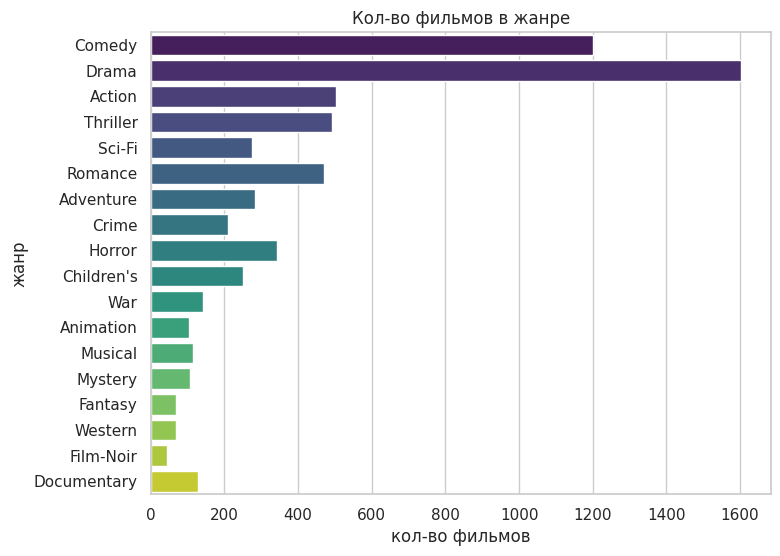

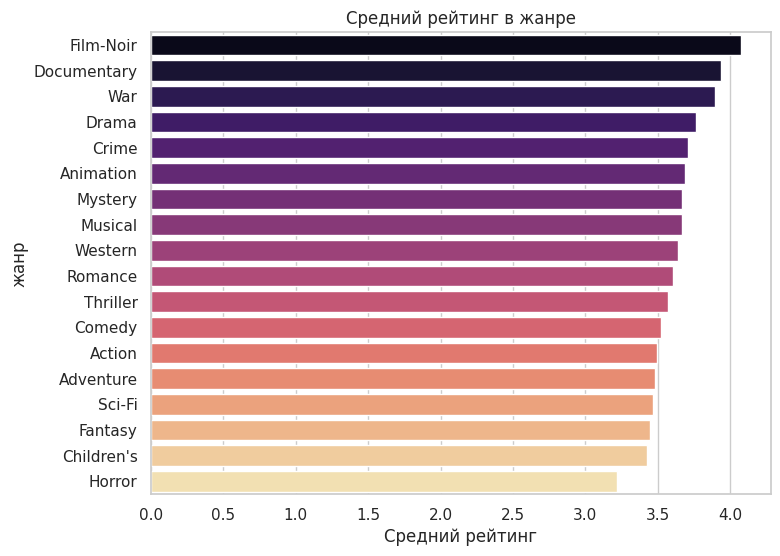

In [ ]:
# Частота жанров по числу фильмов
genre_counter = Counter()
for g_list in df_i['genres_list']:
    genre_counter.update(g_list)
if '(no genres listed)' in genre_counter:
    genre_counter.pop('(no genres listed)')

genre_counts = pd.DataFrame(sorted(genre_counter.items(), key=lambda x: x[1],
                                   reverse=True), columns=['genre','n_movies'])
# Для каждого жанра собираем число рейтингов и средний рейтинг
rows = []
for g in genre_counts['genre']:
    mids = df_i[df_i['genres_list'].apply(lambda lst: g in lst)]['item_id'].unique()
    sub = df[df['item_id'].isin(mids)]
    rows.append({
        'genre': g,
        'n_movies': len(mids),
        'n_ratings': len(sub),
        'mean_rating': sub['rating'].mean() if len(sub)>0 else np.nan,
        'median_rating': sub['rating'].median() if len(sub)>0 else np.nan
    })
genre_df = pd.DataFrame(rows).sort_values('n_ratings', ascending=False)
display(genre_df.head())

plt.figure(figsize=(8,6))
sns.barplot(data=genre_df, x='n_movies', y='genre', palette='viridis')
plt.title('Кол-во фильмов в жанре')
plt.xlabel('кол-во фильмов')
plt.ylabel('жанр')
plt.show()

plt.figure(figsize=(8,6))
sns.barplot(data=genre_df.sort_values('mean_rating', ascending=False),
            x='mean_rating', y='genre', palette='magma')
plt.title('Средний рейтинг в жанре')
plt.xlabel('Средний рейтинг')
plt.ylabel('жанр')
plt.show()

### **замечено:**
- Массовые жанры (Drama, Comedy, Action) - много фильмов,много оценок, но рейтинг средний
- Нишевые жанры (Documentary, War, Film-Noir) - меньше фильмов, но выше рейтинг
- качество ≠ количество

## 13.Временной анализ рейтингов.

,quarter,n_ratings,mean_rating
0,2000Q2,133319,3.616671
1,2000Q3,324864,3.594332


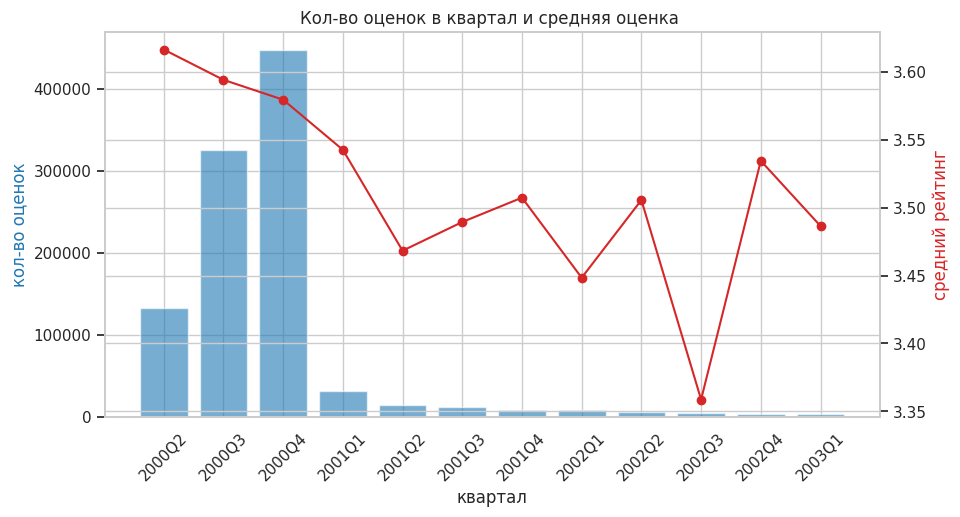

In [ ]:
temp = df.copy()
if temp['ts'].notna().any():
    temp['year'] = temp['ts'].dt.year
    temp['month'] = temp['ts'].dt.to_period('M')
    temp['quarter'] = temp['ts'].dt.to_period('Q')
    # агрегируем поквартально
    quarterly = (temp.groupby('quarter')['rating']
               .agg(n_ratings='count', mean_rating='mean')
               .reset_index())

    display(quarterly.head(2))
    fig, ax1  = plt.subplots(figsize=(10,5))
    ax1.bar(quarterly['quarter'].astype(str), quarterly['n_ratings'],
            alpha=0.6, color='tab:blue')
    ax1.set_xlabel('квартал')
    ax1.set_ylabel('кол-во оценок', color='tab:blue')
    ax1.tick_params(axis='x', rotation=45)

    ax2 = ax1.twinx()
    ax2.plot(quarterly['quarter'].astype(str), quarterly['mean_rating'],
             color='tab:red', marker='o')
    ax2.set_ylabel('средний рейтинг', color='tab:red')
    plt.title('Кол-во оценок в квартал и средняя оценка ')
    plt.show()
else:
    print("чёт не так с ts")

### **замечено:**
- Средний рейтинг не стабилен во времени , не зависит от сезона

## 14.Хвосты и аномалии: супер-пользователи и супер-объекты

In [ ]:
# Хвосты и аномалии: супер-пользователи и супер-объекты
print("Top-10 юзеров по кол-ву оценок")
display(user_activity.head(10))

print("\nTop-10 фильмов по кол-ву оценок")
display(movie_agg.head(10))

Top-10 юзеров по кол-ву оценок


,rating
user_id,
4169,2314
1680,1850
4277,1743
1941,1595
1181,1521
889,1518
3618,1344
2063,1323
1150,1302



Top-10 фильмов по кол-ву оценок


,item_id,title,n_ratings,mean_rating,median_rating,std_rating
2651,2858,American Beauty (1999),3428,4.317386,5.0,0.975133
253,260,Star Wars: Episode IV - A New Hope (1977),2991,4.453694,5.0,0.800781
1106,1196,Star Wars: Episode V - The Empire Strikes Back...,2990,4.292977,4.0,0.844432
1120,1210,Star Wars: Episode VI - Return of the Jedi (1983),2883,4.022893,4.0,0.927356
466,480,Jurassic Park (1993),2672,3.763847,4.0,0.969777
1848,2028,Saving Private Ryan (1998),2653,4.337354,5.0,0.845775
575,589,Terminator 2: Judgment Day (1991),2649,4.058513,4.0,0.904823
2374,2571,"Matrix, The (1999)",2590,4.315830,5.0,0.930918
1178,1270,Back to the Future (1985),2583,3.990321,4.0,0.865188
579,593,"Silence of the Lambs, The (1991)",2578,4.351823,5.0,0.831542


### **замечено:**
- Пользователи
- - 10 самых активных оценили от 1 300 до 2 300 фильмов
- - << 1 % от всех юзеров, но они дают десятки тысяч оценок и оказывают сильное влияние на средние рейтинги
- Фильмы
- - Самые популярные ленты набрали 2500-3500 оценок
- - это классика 90-х, средний рейтинг 3.7-4.5
- - но даже у «лидеров» std ~ 0.8-0.97 , мнения юзеров всё же различаются

## 15. **Общие Выводы:**

- Датасет разреженный с плотностью ~0.045 и средней активностью по 165 рейтингов на пользователя и ~270 рейтингов на фильм.

- Рейтинги смещены в сторону высоких значений, медиана и 75-й персентиль 4.0, дисперсия умеренная (std ~1.12).

- Наличие небольшого числа «супер‑пользователей» (10 пользователей дают тысячи оценок) создаёт сильное воздействие на средние.

- Популярность и средний рейтинг имеют среднюю корреляцию ( ~0.36).

- Жанровая картина: массовые жанры дают много фильмов с нейтральным средним рейтингом; нишевые жанры часто имеют более высокий средний рейтинг.

- Средний рейтинг не стабилен во времени , не зависит от сезона

# **Стратегия валидации.**

  **План разбиения на train и test:**  
**Вариант A - случайное стратифицированное разбиение:**  
- train 80% / test 20%.  
- сохранять минимум N оценок в train для каждого пользователя и предмета,
- сохранять минимум k оценок в test  
  
**Плюсы:**
- Простота реализации
- Обеспечивает представительность всех пользователей и предметов  
  
**Минусы:**
- Не учитывает временные зависимости
- Не моделирует реальный production-сценарий, где модель обучается на старых данных и предсказывает будущее поведение    

**Вывод:**
- Подходит для baseline-моделей, но не рекомендуется для финального тестирования в рекомендательных системах, где важна временная динамика.
---  

**Вариант B - разбиение по времени(Time-based split):**  
- train 80% / test 20%  разделение по временному порогу
- Моделирует production-сценарий    

**Плюсы:**  
- Учитывает временные сдвиги в поведении пользователей
- Моделирует реальный сценарий: модель обучается на прошлых данных и предсказывает будущие взаимодействия  

**Минусы:**
- Может быть неравномерным по пользователям: у некоторых может не оказаться данных в test
- Требует осторожной обработки "холодных" пользователей/предметов    

**Вывод:**  
- Рекомендуется для финальной оценки модели в рекомендательных системах.  

---  

**Вариант C - leave-one-out(leave‑last‑k):**

- Для каждого пользователя последнее или несколько последних взаимодействий убирается в test
- Всё остальное - в train   
    
**Плюсы:**  
- Моделирует реалистичный сценарий предсказания следующего действия
- Позволяет персонализировать оценку качества для каждого пользователя  
  
**Минусы:**  
- Может быть вычислительно затратным при большом числе пользователей
- Требует аккуратной реализации, чтобы избежать утечки данных  
  
**Вывод:**
- Один из лучших подходов для top-N задач и оценки ранжирования.


## 16. Вариант B - разбиение по времени(Time-based split)
Выбираем  порог времени 80% . Все события до порога в train, события после в test. Это гарантирует, что ни одно событие из "будущего" не попадёт в train.

In [ ]:
# колонки для сохранения
columns_to_save = ['user_id', 'item_id', 'rating', 'timestamp', 'title', 'genres']
# limit
time_treshold = df['ts'].quantile(q=0.8, interpolation='nearest')
print(f"Порог разбиения по времени {time_treshold}")

train_df = df[df['ts'] <= time_treshold][columns_to_save]
test_df = df[df['ts'] > time_treshold][columns_to_save]
print(f"Размеры train {train_df.shape[0]} test {test_df.shape[0]}")

users_intersection = set(test_df['user_id']) & set(train_df['user_id'])
print(f"train содержит {train_df['user_id'].nunique()} пользователей\t и {train_df.shape[0]} строк,\
\ntest содержит  { test_df['user_id'].nunique()} пользователей \t и {test_df.shape[0]} строк,\
\n{len(users_intersection)} юзера встречаются одновременно и в train и в test")

# залистим тестовых пользователей
test_users = sorted(users_intersection)

print('\ntrain ')
display(train_df.head(2))
print('\ntest ')
display(test_df.head(2))

Порог разбиения по времени 2000-12-02 14:52:18
Размеры train 800168 test 200041
train содержит 5400 пользователей	 и 800168 строк,
test содержит  1783 пользователей 	 и 200041 строк,
1143 юзера встречаются одновременно и в train и в test

train 


,user_id,item_id,rating,timestamp,title,genres
94507,635,1251,4,975768620,8 1/2 (1963),Drama
94513,635,3948,4,975768294,Meet the Parents (2000),Comedy



test 


,user_id,item_id,rating,timestamp,title,genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical


## 17 подготовка train - test данных.

Необходимо выкинуть из train холодных пользоватей
- для модели недостаточно данных для выявления паттерна пользователя , обучение становиться более шумным
-  холодным пользователям рекомендуем популярное, контент или онбординг, нет смысла обучать на них модель

In [ ]:
# минимальное тёплое число оценок
min_n_reitings = 5

# сколько у каждого юзера
user_counts = train_df['user_id'].value_counts()

# список "теплых"
warm_users = user_counts[user_counts >= min_n_reitings].index

# выбрасываем холодных
warm_train_df = train_df[train_df['user_id'].isin(warm_users)]

print(f"Осталось пользователей в train : {len(warm_users)}")
print(f"Новый размер train: {warm_train_df.shape}")

Осталось пользователей в train : 5392
Новый размер train: (800142, 6)


Хотелось бы в тесте видеть пользователей у которых:
- в тесте есть минимум 10 оценок для метрик ражнжирования
- в train >= 15 оценок для обучения модели
- все items в test присутствуют в train

In [ ]:
# оставляем в test только item'ы, которые есть в train
train_items = set(warm_train_df['item_id'].unique())
good_test_df = test_df[test_df['item_id'].isin(train_items)]

# min кол-во оценок у каждого юзера в train и в test
n, k = 15, 10
train_n_rait = warm_train_df['user_id'].value_counts()
test_n_rait = good_test_df['user_id'].value_counts()

good_users = (set(train_n_rait[train_n_rait >= n].index)
              & set(test_n_rait[test_n_rait >= k].index))

good_test_df = good_test_df[good_test_df['user_id'].isin(good_users)]


print(f"Осталось пользователей в test: {len(good_users)}")
print(f"test shape: {good_test_df.shape}")

Осталось пользователей в test: 836
test shape: (94842, 6)


## 18. сохраняет подготовленные train/test в отдельные файлы

In [ ]:
# папка для сохранения данных
time_stamp = datetime.now().strftime('%y%m%d_%H%M%S')
out_dir = PROCESSED/f'{time_stamp}'
out_dir.mkdir(parents=True, exist_ok=True)

# сохраняем сами данные
warm_train_df.to_csv(out_dir / 'train.csv', index=False)
good_test_df.to_csv(out_dir / 'test.csv', index=False)

# мета-информация
meta = {
    'created_at': datetime.now().isoformat(),
    'train_shape': warm_train_df.shape,
    'test_shape': good_test_df.shape,
    'time_treshold': time_treshold.isoformat(),
    'n_train_users': int(warm_train_df['user_id'].nunique()),
    'n_test_users': int(good_test_df['user_id'].nunique()),
    'n_items': int(warm_train_df['item_id'].nunique()),
    'min_train_interactions': 5,
    'min_test_interactions': 10,
    'columns': list(warm_train_df.columns)
}

with open(out_dir / 'meta.json', 'w', encoding='utf8') as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print(f'Time_split train/test сохранён в {out_dir.absolute()}')

Time_split train/test сохранён в /content/drive/MyDrive/Colab Notebooks/data/processed/251021_173655


## 19 Прочитаем данные

In [4]:
# чтение train/test
out_dir = PROCESSED/'251021_173655'
data_path =  out_dir.absolute()

def train_test_reader(d_path = data_path):
    # читаем мета-информацию
    with open(d_path / 'meta.json', 'r', encoding='utf-8') as f:
        meta = json.load(f)
    # читаем сами датасеты
    train = pd.read_csv(d_path / 'train.csv')
    test  = pd.read_csv(d_path / 'test.csv')
    return train, test, meta

train, test, meta = train_test_reader()
pprint(meta, width=80, compact=False)
print(f'\ntrain shape : {train.shape}')
print(f'test shape  : {test.shape}')
display(train.head())

{'columns': ['user_id', 'item_id', 'rating', 'timestamp', 'title', 'genres'],
 'created_at': '2025-10-21T17:37:00.607645',
 'min_test_interactions': 10,
 'min_train_interactions': 5,
 'n_items': 3662,
 'n_test_users': 836,
 'n_train_users': 5392,
 'test_shape': [94842, 6],
 'time_treshold': '2000-12-02T14:52:18',
 'train_shape': [800142, 6]}

train shape : (800142, 6)
test shape  : (94842, 6)


,user_id,item_id,rating,timestamp,title,genres
0,635,1251,4,975768620,8 1/2 (1963),Drama
1,635,3948,4,975768294,Meet the Parents (2000),Comedy
2,635,1270,4,975768106,Back to the Future (1985),Comedy|Sci-Fi
3,635,1279,5,975768520,Night on Earth (1991),Comedy|Drama
4,635,1286,4,975768106,Somewhere in Time (1980),Drama|Romance


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94842 entries, 0 to 94841
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    94842 non-null  int64 
 1   item_id    94842 non-null  int64 
 2   rating     94842 non-null  int64 
 3   timestamp  94842 non-null  int64 
 4   title      94842 non-null  object
 5   genres     94842 non-null  object
dtypes: int64(4), object(2)
memory usage: 4.3+ MB


# **МЕТРИКИ**
(позже добавим ещё немножк)

## 20. HitRate   
$HitRate@K$
- доля пользователей, среди top-K рекомендованных items, хотя бы один оказался в их test-списке.  
- бинарно: 1 - попал хоть один, 0 - ни одного.
- самая простая  метрика для top-K задач.
---

$$HitRate@K(u) = \max_{j \in [1..K]}\mathbb{1}_{r_{uj}}$$


$$ HitRate@K = \frac{\sum_{u=1}^{N}HitRate@K(u)}{N} $$

$\mathbb{1}_{r_{uj}}$ - индикатор пересечения юзера u фильма(item) j

In [5]:
def hitrate_at_k(rec_items: dict[int, list[int]],  # {user_id: [item_id, ...]}
                 test_items: dict[int, set[int]],            # {user_id: {item_id, ...}}
                 k: int = 10) -> float:
    '''
    HitRate@K
    rec_items - топ-K items
    test_items - item-ы поюзерно из test
    '''
    if rec_items.keys() != test_items.keys():
        print('Achtung!!! hitrate_at_k\nРазный набор юзеров.')
        return None
    hr = 0 # сумма всех HitRate@K(u)
    for us, recs  in rec_items.items():
      if set(recs[:k]) & test_items[us]:
        hr+=1
    return hr/len(test_items)

## 21. Coverage
- измеряет насколько разнообразные объекты система способна рекомендовать. Она показывает, какую долю всех возможных предметов (или пользователей) система реально охватывает в своих рекомендациях.  
---
$$Coverage@K=\frac{\left|\bigcup\limits_{u\in U} y_u\right|}{|I|}$$  
- 𝑈 - множество пользователей в тестовой выборке

- $y_u$  - множество рекомендованных item'ов (например, топ‑K) для пользователя 𝑢

- 𝐼 - множество всех уникальных item-ов в датасете

In [6]:
def coverage_at_k(rec_items: dict[int, list[int]],  # {user_id: [item_id, ...]}
                  all_items: set[int],              # set(user_id)
                  k=10)-> float:
    '''
    recs: словарь user_id -> list of item_id (top-K)
    '''
    rec_items_set = set()
    for recs in rec_items.values():
        rec_items_set.update(recs[:k])
    return len(rec_items_set) / len(all_items)

## **22. Precision@K**  
$Precision@K$  
- доля релевантных элементов среди первых $K$ рекомендованных для каждого пользователя.  
- для бинарной релевантности: релевантный = 1, нерелевантный = 0.  
- хороша для оценки чистой «точности» списка рекомендаций.  
---

$$Precision@K(u)=\frac{1}{K}\sum_{j=1}^{K}\mathbb{1}_{r_{uj}}$$

$$Precision@K=\frac{1}{N}\sum_{u=1}^{N}Precision@K(u)$$

$\mathbb{1}_{r_{uj}}$ - индикатор релевантности рекомендованного item‑а $j$ для пользователя $u$; $N$ - число пользователей в тестовой выборке.

In [7]:
def precision_at_k(rec_items: dict[int, list[int]],  # {user_id: [item_id, ...]}
                   test_items: dict[int, set[int]],    # {user_id: {item_id, ...}}
                   k: int = 10) -> float:
    """
    rec_items - словарь user_id -> list of item_id (top-K)
    test_items - item-ы поюзерно из test
    """
    if rec_items.keys() != test_items.keys():
        print('Achtung!!! precision_at_k\nРазный набор юзеров.')
        return None
    total = 0.0
    for u, recs in rec_items.items():
        topk = recs[:k]
        hits = len(set(topk) & test_items[u])
        total += hits
    return total/ k/ len(test_items)


## 23. **Recall@K**  
$Recall@K$  
- доля всех релевантных объектов пользователя, найденных в топ‑$K$.  
- чувствительна к числу релевантных объектов в тесте для каждого пользователя.  
- полезна, когда важно покрыть максимум релевантного набора пользователя.  
---

$$Recall@K(u)=\frac{\sum_{j=1}^{K}\mathbb{1}_{r_{uj}}}{R_u}$$

$$Recall@K=\frac{1}{N}\sum_{u=1}^{N}Recall@K(u)$$

$R_u$ — число релевантных item‑ов в тестовой выборке для пользователя $u$.

In [8]:
def recall_at_k(rec_items: dict[int, list[int]],  # {user_id: [item_id, ...]}
                test_items: dict[int, set[int]],    # {user_id: {item_id, ...}}],
                k: int = 10) -> float:
    """
    Recall@K
    """
    if rec_items.keys() != test_items.keys():
        print('Achtung!!! recall_at_k\nРазный набор юзеров.')
        return None
    total = 0.0
    for u, recs in rec_items.items():
        R_u = len(test_items[u])
        # можно: считать как 0 или исключать из среднего;
        # здесь исключаем из суммы и учёта
        # но так как у нас R_u всегда >=10, то это лишнее
        if R_u == 0:
            print('Achtung!!! recall_at_k\nВ test есть юзеры с 0 items !!!')
            continue
        topk = recs[:k]
        hits = len(set(topk) & test_items[u])
        total += hits / R_u
    # нормируем на число пользователей с R_u>0
    num_with_pos = sum(1 for s in test_items.values() if len(s) > 0)
    return total / num_with_pos if num_with_pos > 0 else 0.0


## 24. NDCG@K  
$NDCG@K$  
- Normalized Discounted Cumulative Gain; учитывает позицию и градуированную релевантность (например рейтинг).  
- повышает вес релевантных item‑ов, стоящих выше в списке.  
- рекомендуется использовать с градуированной релевантностью (рейтинг MovieLens) или бинарной релевантностью с порогом.  
---

$$DCG@K(u)=\sum_{j=1}^{K}\frac{2^{rel_{uj}}-1}{\log_2(j+1)}$$

$$IDCG@K(u)=\max_{\text{perm}}\; DCG@K(u)\quad\text{(DCG лучшего упорядочивания)}$$

$$NDCG@K(u)=\frac{DCG@K(u)}{IDCG@K(u)}$$

$$NDCG@K=\frac{1}{N}\sum_{u=1}^{N}NDCG@K(u)$$

$rel_{uj}$ - релевантность item‑а $j$ для пользователя $u$ (градуированная или бинарная).


In [9]:
def ndcg_at_k(rec_items: dict[int, list[int]],  # {user_id: [item_id, ...]}
              test_items: dict[int, set[int]],    # {user_id: {item_id, ...}}],
              k: int = 10) -> float:
    """
    NDCG@K с бинарным ранжированием
    """
    if rec_items.keys() != test_items.keys():
        print('Achtung!!! ndcg_at_k\nРазный набор юзеров.')
        return None

    def dcg(rels: list[int]) -> float:
        return sum((2**r - 1) / math.log2(i + 2) for i, r in enumerate(rels))  # i starts 0 -> position i+1

    total_ndcg = 0.0
    num_users = 0
    for u, recs in rec_items.items():
        R_u = len(test_items[u])
        if R_u == 0:
            print('Achtung!!! ndcg_at_k\nВ test есть юзеры с 0 items !!!')
            continue
        topk = recs[:k]
        rels = [1 if item in test_items[u] else 0 for item in topk]
        user_dcg = dcg(rels)
        ideal_rels = [1] * min(R_u, k)
        user_idcg = dcg(ideal_rels)
        if user_idcg > 0:
            total_ndcg += user_dcg / user_idcg
        else:
            total_ndcg += 0.0
        num_users += 1
    return total_ndcg / num_users if num_users > 0 else 0.0


## 25. **MAP@K**  
$MAP@K$  
- Mean Average Precision at K; усреднённое по пользователям значение Average Precision@K.  
- учитывает порядок появления релевантных элементов: даёт больше веса тем, которые появляются раньше.  
- хорошо работает в задачах с несколькими релевантными элементами на пользователя.  
---

$$AP@K(u)=\frac{1}{\min(R_u,K)}\sum_{j=1}^{K}Precision@j(u)\cdot \mathbb{1}_{r_{uj}}$$

$$MAP@K=\frac{1}{N}\sum_{u=1}^{N}AP@K(u)$$

$Precision@j(u)$ - precision для первых $j$ позиций у пользователя $u$; $R_u$ - число релевантных item‑ов в тесте для $u$.

In [10]:
def map_at_k(rec_items: dict[int, list[int]],  # {user_id: [item_id, ...]}
             test_items: dict[int, set[int]],    # {user_id: {item_id, ...}}],
             k: int = 10) -> float:
    """
    MAP@K (Mean Average Precision @ K) с бинарной релевантностью.
    AP@K(u) = 1/min(R_u,K) * sum_{i=1..K} Precision@i(u) * rel_i
    """
    if rec_items.keys() != test_items.keys():
        print('Achtung!!! map_at_k\nРазный набор юзеров.')
        return None

    total_ap = 0.0
    num_users = 0
    for u, recs in rec_items.items():
        R_u = len(test_items[u])
        if R_u == 0:
            print('Achtung!!! map_at_k\nВ test есть юзеры с 0 items !!!')
            continue
        topk = recs[:k]
        hits = 0
        sum_prec = 0.0
        for i, item in enumerate(topk, start=1):
            if item in test_items[u]:
                hits += 1
                sum_prec += hits / i  # Precision@i for this user
        denom = min(R_u, k)
        ap = sum_prec / denom if denom > 0 else 0.0
        total_ap += ap
        num_users += 1
    return total_ap / num_users if num_users > 0 else 0.0


# **Baseline (most popular)**

---
- тупо каждому пользователю предсказываем самые популярные киношки



In [15]:
def model_evaluation(rec_items: dict[int, list[int]],           # рекомендации поюзерно
                              test_items: dict[int, set[int]],  # item-ы поюзерно из test
                              all_items: set[int],
                              k: int = 10,
                              model_name: str = "model") -> pd.DataFrame:
    """
    Возвращает результат в pandas.DataFrame
    """
    hr = hitrate_at_k(rec_items, test_items, k=k)
    pr_k = precision_at_k(rec_items, test_items, k=k)
    rec_k = recall_at_k(rec_items, test_items, k=k)
    ndcg = ndcg_at_k(rec_items, test_items, k=k)
    map_k = map_at_k(rec_items, test_items, k=k)
    cov = coverage_at_k(rec_items, all_items, k=k)
    df = pd.DataFrame(
        [[hr, pr_k, rec_k, ndcg, map_k, cov]],
        index=[model_name],
        columns=[f"hit_rate@{k}", f"precision@{k}", f"recall@{k}",
                 f"ndcg@{k}", f"map@{k}", f"coverage@{k}"]
    )
    return df

In [16]:
k = 10
popular_items = train['item_id'].value_counts().head(k).index.to_list()
test_dict   = test.groupby('user_id')['item_id'].apply(set).to_dict()
rec_items = {user : popular_items for user in test_dict}
all_items = set(train['item_id'].unique())

result = model_evaluation(rec_items, test_dict, all_items, k=k, model_name='Most_Popular')
display(result)

,hit_rate@10,precision@10,recall@10,ndcg@10,map@10,coverage@10
Most_Popular,0.51555,0.132895,0.015591,0.133171,0.068656,0.002731


#### **Вывод:**
- HitRate@10 = 0.51555 - более половины пользователей получают в топ‑10 хотя бы один релевантный популярный фильм  
- Precision@10 = 0.1329 - в среднем ~1.33 релевантных элемента на 10 предложенных, поюзерная точность низкая, но не нулевая  
- Recall@10 = 0.0156 - модель покрывает очень малую долю всех релевантных item-ов пользователяб низкий Recall объясняется тем, что у пользователей может быть много релевантных объектов, а мы предлагаем лишь 10 , ну и попадаем слабовато  
- NDCG@10 = 0.1332 - ранжирование не даёт высокого раннего попадания порядок популярных элементов мало совпадает с индивидуальными предпочтениями  
- MAP@10 = 0.0687 — средняя аппроксимированная точность с учётом порядка низкая, много релевантных элементов появляются далеко от начала
- Coverage@10 = 0.002731 очень низкий, используется крайне малая доля каталога.

# **Сохранение результата**

In [18]:
# Сохранение результатов оценки модели
# Создаем директорию для результатов
results_dir = DATA / "results"
results_dir.mkdir(exist_ok=True)

# Генерируем уникальное имя файла с временной меткой
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = 'Most_Popular'

# Подготавливаем результаты для сохранения
results_data = {
    'model_name': model_name,
    'evaluation_date': datetime.now().isoformat(),
    'metrics': {
        'hit_rate@10': result.iloc[0]['hit_rate@10'],
        'precision@10': result.iloc[0]['precision@10'],
        'recall@10': result.iloc[0]['recall@10'],
        'ndcg@10': result.iloc[0]['ndcg@10'],
        'map@10': result.iloc[0]['map@10'],
        'coverage@10': result.iloc[0]['coverage@10']
    },
    'parameters': {
        'k': k,
        'min_train_interactions': meta['min_train_interactions'],
        'min_test_interactions': meta['min_test_interactions']
    },
    'dataset_info': {
        'n_train_users': meta['n_train_users'],
        'n_test_users': meta['n_test_users'],
        'n_items': meta['n_items'],
        'train_size': meta['train_shape'][0],
        'test_size': meta['test_shape'][0]
    }
}

# Сохраняем результаты в JSON с уникальным именем
results_json_file = results_dir / f'{model_name}_{timestamp}.json'
with open(results_json_file, 'w', encoding='utf-8') as f:
    json.dump(results_data, f, indent=2, ensure_ascii=False, default=str)

# Для CSV создаем/обновляем сводную таблицу всех экспериментов
results_csv_file = results_dir / 'all_experiments_results.csv'

# Создаем DataFrame для текущего результата с временной меткой и именем модели
current_result = result.reset_index().rename(columns={'index': 'model_name'})
current_result['timestamp'] = timestamp
current_result['evaluation_date'] = results_data['evaluation_date']

if results_csv_file.exists():
    # Если файл существует, читаем и добавляем новую строку
    existing_results = pd.read_csv(results_csv_file)
    updated_results = pd.concat([existing_results, current_result], ignore_index=True)
    updated_results.to_csv(results_csv_file, index=False)
    print("Результат добавлен в существующий CSV файл")
else:
    # Если файла нет, создаем новый
    current_result.to_csv(results_csv_file, index=False)
    print("Создан новый CSV файл с результатами")

print(f"JSON результат сохранен как: {results_json_file.name}")
print(f"CSV со всеми экспериментами: {results_csv_file.name}")
print(f"Все результаты в: {results_dir}")

# Выводим сводку по эксперименту
print("\n" + "="*50)
print("СВОДКА ЭКСПЕРИМЕНТА")
print("="*50)
print(f"Модель: {results_data['model_name']}")
print(f"Метка времени: {timestamp}")
print(f"Дата оценки: {results_data['evaluation_date'][:19]}")
print(f"Размер train: {results_data['dataset_info']['train_size']:,}")
print(f"Размер test: {results_data['dataset_info']['test_size']:,}")
print(f"Пользователей в test: {results_data['dataset_info']['n_test_users']}")
print(f"Уникальных предметов: {results_data['dataset_info']['n_items']}")
print(f"HitRate@10: {results_data['metrics']['hit_rate@10']:.1%}")
print(f"precision@10: {results_data['metrics']['precision@10']:.2%}")
print(f"recall@10: {results_data['metrics']['recall@10']:.2%}")
print(f"ndcg@10: {results_data['metrics']['ndcg@10']:.2%}")
print(f"map@10: {results_data['metrics']['map@10']:.2%}")
print(f"Coverage@10: {results_data['metrics']['coverage@10']:.2%}")
print("="*50)

# Дополнительно: показываем последние 5 экспериментов если CSV существует
if results_csv_file.exists():
    all_results = pd.read_csv(results_csv_file)
    print(f"\nПоследние эксперименты ({len(all_results)} всего):")
    display(all_results.tail(5))

Создан новый CSV файл с результатами
JSON результат сохранен как: Most_Popular_20251022_194247.json
CSV со всеми экспериментами: all_experiments_results.csv
Все результаты в: /content/drive/MyDrive/Colab Notebooks/data/results

СВОДКА ЭКСПЕРИМЕНТА
Модель: Most_Popular
Метка времени: 20251022_194247
Дата оценки: 2025-10-22T19:42:47
Размер train: 800,142
Размер test: 94,842
Пользователей в test: 836
Уникальных предметов: 3662
HitRate@10: 51.6%
precision@10: 13.29%
recall@10: 1.56%
ndcg@10: 13.32%
map@10: 6.87%
Coverage@10: 0.27%

Последние эксперименты (1 всего):


,model_name,hit_rate@10,precision@10,recall@10,ndcg@10,map@10,coverage@10,timestamp,evaluation_date
0,Most_Popular,0.51555,0.132895,0.015591,0.133171,0.068656,0.002731,20251022_194247,2025-10-22T19:42:47.576490


# Чтение результата

In [19]:
csv_path = results_dir/"all_experiments_results.csv"
results_df = pd.read_csv(csv_path)
results_df

,model_name,hit_rate@10,precision@10,recall@10,ndcg@10,map@10,coverage@10,timestamp,evaluation_date
0,Most_Popular,0.51555,0.132895,0.015591,0.133171,0.068656,0.002731,20251022_194247,2025-10-22T19:42:47.576490


In [20]:
json_path = results_dir/"Most_Popular_20251022_194247.json"

with open(json_path, 'r', encoding='utf-8') as f:
    meta_1 = json.load(f)

# Показываем содержимое в красивом формате
print("metа:")
pprint(meta_1,width=80, compact=False)

metа:
{'dataset_info': {'n_items': 3662,
                  'n_test_users': 836,
                  'n_train_users': 5392,
                  'test_size': 94842,
                  'train_size': 800142},
 'evaluation_date': '2025-10-22T19:42:47.576490',
 'metrics': {'coverage@10': 0.002730748225013654,
             'hit_rate@10': 0.5155502392344498,
             'map@10': 0.0686564422419686,
             'ndcg@10': 0.13317065367741812,
             'precision@10': 0.13289473684210526,
             'recall@10': 0.015591192340500706},
 'model_name': 'Most_Popular',
 'parameters': {'k': 10,
                'min_test_interactions': 10,
                'min_train_interactions': 5}}
